In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 28,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
lattice_file = shift.get_6dsim_dir()\
                    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt")
lattice_df = lattice.read_lattice_file(lattice_file)

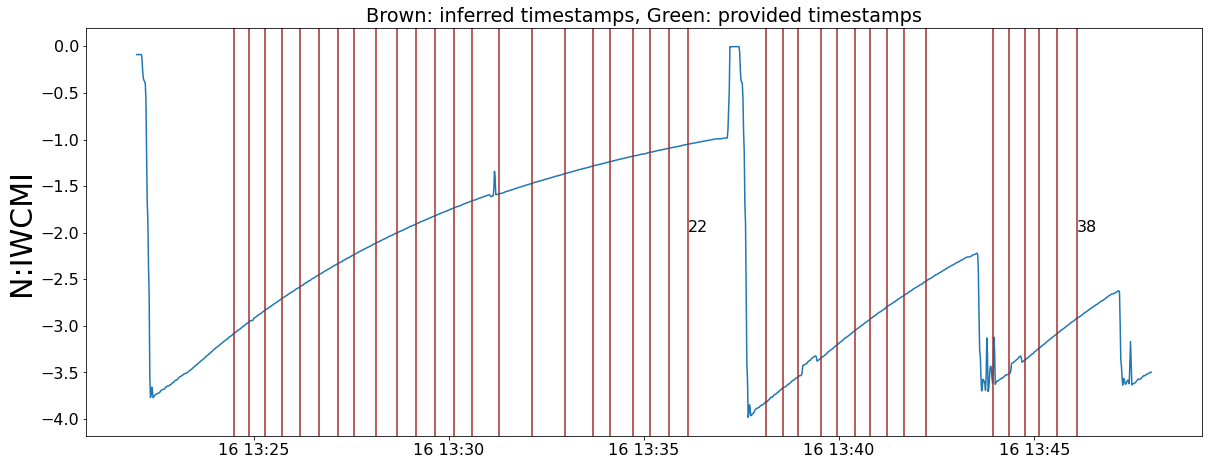

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:172: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)
/home/ilobach/fur/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [2]:
res_df_FLAT = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_FLAT_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_FLAT_case_03_16_2020.csv',
    show_plot=True
)
acnted_df_FLAT = shift.get_acnet_data_df('all_acnet_data_FLAT_case_03_16_2020.csv')
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv'
)
acnted_df_ROUND = shift.get_acnet_data_df('all_acnet_data_ROUND_case_03_16_2020.csv')
res_df_ROUND_Low_RF = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_LONG_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)
acnted_df_ROUND_Low_RF = shift.get_acnet_data_df('all_acnet_data_ROUND_low_RF_case_03_16_2020.csv')

In [3]:
rdt = res_df_FLAT['real_datetime']
time_intervals = [[rdt[0], rdt[22]], [rdt[23], rdt[32]], [rdt[33], rdt[38]]]
def in_time_intervals(row):
    t = row.name
    return True in [(t>ti[0] and t<ti[1]) for ti in time_intervals]
time_intervals[0][0] = time_intervals[0][0]-pd.Timedelta(seconds=60)
time_intervals

[[Timestamp('2020-03-16 13:23:29'), Timestamp('2020-03-16 13:36:07')],
 [Timestamp('2020-03-16 13:38:08'), Timestamp('2020-03-16 13:42:13')],
 [Timestamp('2020-03-16 13:43:56'), Timestamp('2020-03-16 13:46:05')]]

In [4]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")

In [5]:
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')

In [6]:
Mfunc, Mxder, Myder, Mzder, Meder = get_M_interpolator_at_fixed_energy()

In [7]:
size_names = ['Sigma_um_X', 'Sigma_um_Y', 'N:IWCMBE']
def var_theor(x, M):
    return x+1/M*x**2

In [8]:
for fluctuations_df in [res_df_FLAT, res_df_ROUND, res_df_ROUND_Low_RF]:
    N = sum_channel_to_photoelectrons*fluctuations_df["ch2_amplitude"].values
    varN = 2*sum_channel_to_photoelectrons**2*fluctuations_df["var_of_ch1_amplitude"].values
    fluctuations_df['N'] = N
    fluctuations_df['varN'] = varN
    fluctuations_df['varN_theor'] = fluctuations_df.apply(lambda row: var_theor(row['N'],Mfunc(row['Sigma_um_X'], row['Sigma_um_Y'], row['N:IWCMBE'])),axis=1) 

In [9]:
# plt.plot(res_df_FLAT["ch2_amplitude"],res_df_FLAT["var_of_ch1_amplitude"] ,'.', label="FLAT")
# plt.plot(res_df_ROUND["ch2_amplitude"],res_df_ROUND["var_of_ch1_amplitude"] ,'.', label="ROUND")
# plt.plot(res_df_ROUND_Low_RF["ch2_amplitude"],res_df_ROUND_Low_RF["var_of_ch1_amplitude"] ,'.', label="ROUND_LONG")
# x_f = np.linspace(0,max(res_df_FLAT["ch2_amplitude"]),1000)
# plt.xlabel("Sum channel amplitude, V")
# plt.ylabel("Variance of the difference channel amplitude, V$^2$")
# plt.title(r"Shift 03-16-2020")
# plt.legend()
# plt.savefig(results_dir.fi("no_nd_filters_variable_beam_current.png"), bbox_inches='tight')
# plt.show()

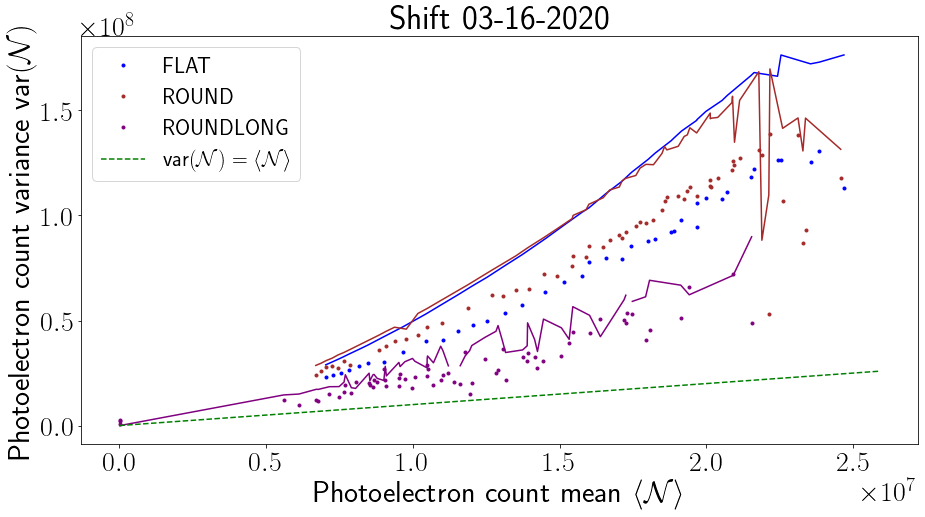

In [10]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"FLAT": 'blue', "ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'FLAT': res_df_FLAT, 'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

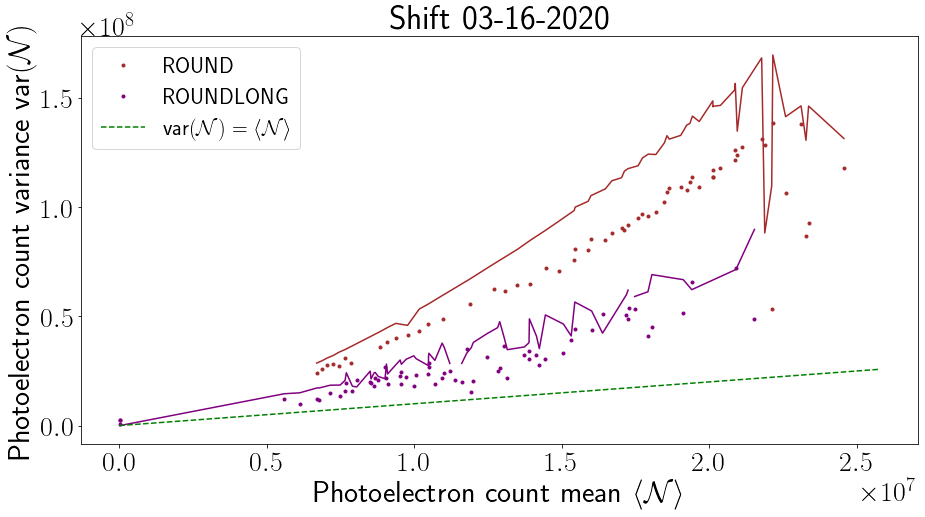

In [11]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
colors = {"ROUND": 'brown', "ROUNDLONG": 'purple'}
data_sets = {'ROUND': res_df_ROUND ,'ROUNDLONG': res_df_ROUND_Low_RF}
fig, ax = plt.subplots(figsize=(15, 7.5))
for name, df in data_sets.items():
    ax.plot(
        df["N"],
        df["varN"],
        '.', label=name, color=colors[name])
    df_N_sorted = df.sort_values('N')
    ax.plot(
        df_N_sorted["N"],
        df_N_sorted["varN_theor"]
        ,'-', color=colors[name])
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
ax.set_title(r"Shift 03-16-2020")
ax.legend()
plt.show()

In [12]:
# acnet_df_FLAT_with_bunch_sizes = get_acnet_df_with_bunch_sizes(
#     shift,
#     "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
#     acnted_df_FLAT
# )

In [13]:
# acnet_df_FLAT_with_bunch_sizes.to_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_FLAT_case_03_16_2020.csv'))

In [14]:
acnet_df_FLAT_with_bunch_sizes = pd.read_csv(shift.get_acnet_data_dir().fi('all_acnet_data_with_bunch_sizes_FLAT_case_03_16_2020.csv'), index_col=0, parse_dates=True)
acnet_df_FLAT_with_bunch_sizes_in_time_intervals = acnet_df_FLAT_with_bunch_sizes[acnet_df_FLAT_with_bunch_sizes.apply(in_time_intervals, axis=1).values]

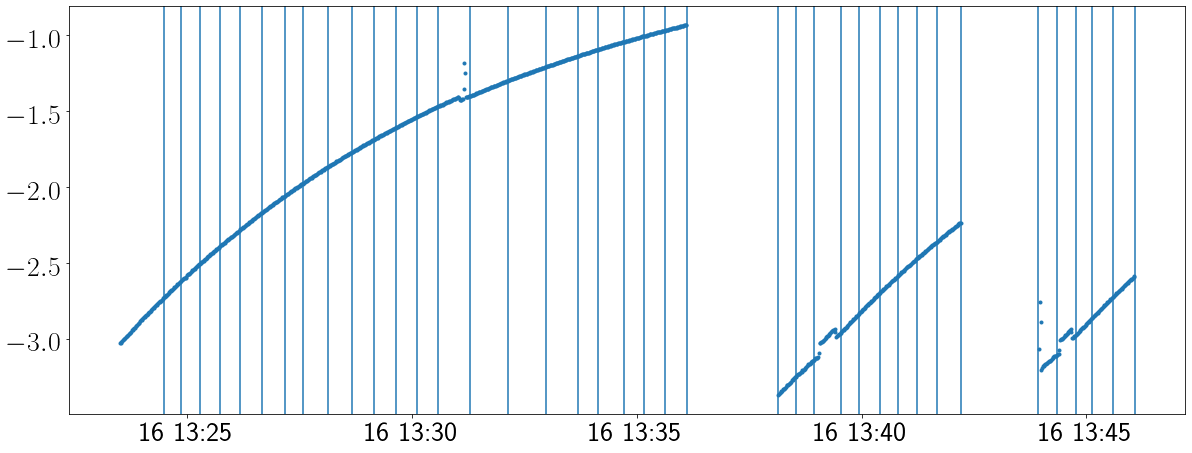

In [15]:
df = acnet_df_FLAT_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI_recalibrated_to_IWCMI_absolute'],'.')
for t in res_df_FLAT['real_datetime']:
    ax.axvline(t)
plt.show()

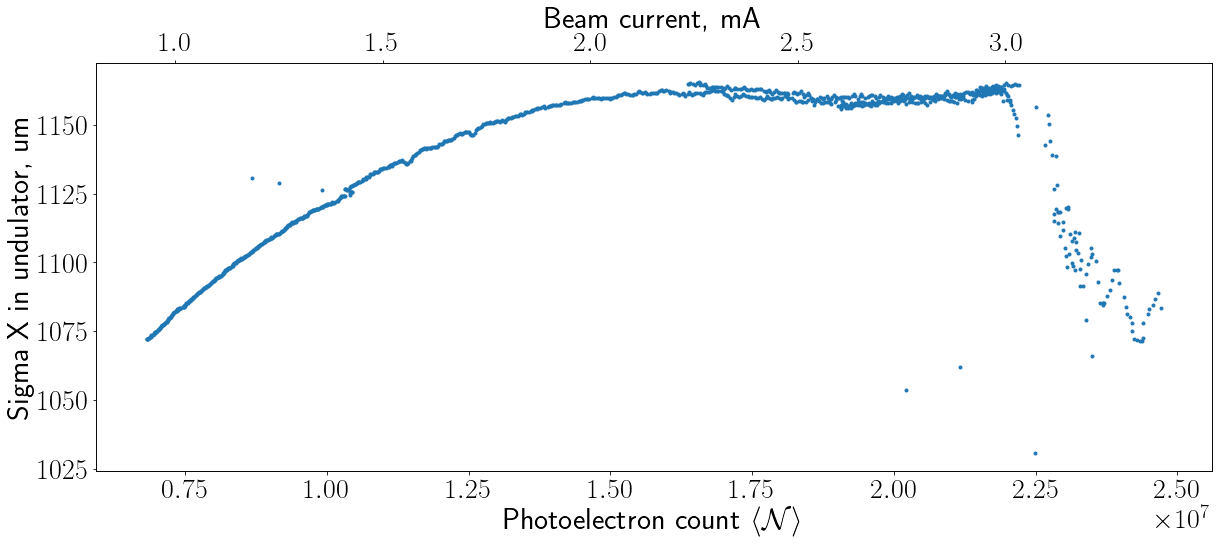

In [16]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_FLAT_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

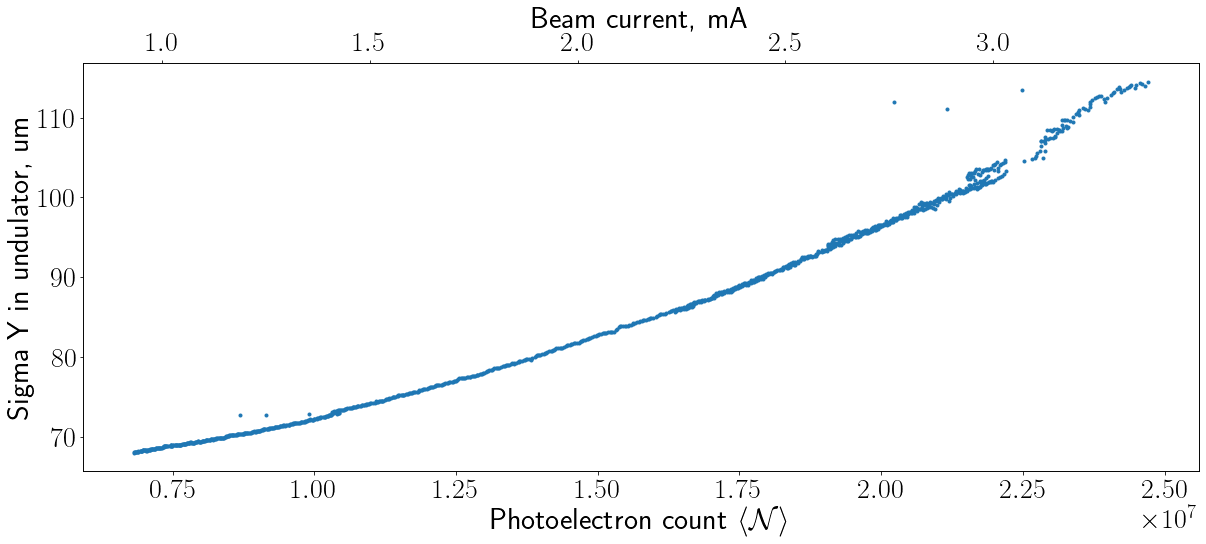

In [17]:
from matplotlib import rc
rc("text", usetex=True)
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
df = acnet_df_FLAT_with_bunch_sizes_in_time_intervals
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

# Leaving only first injection:

In [18]:
first_injection = acnet_df_FLAT_with_bunch_sizes_in_time_intervals[
    acnet_df_FLAT_with_bunch_sizes_in_time_intervals.index<time_intervals[0][1]]
second_injection = acnet_df_FLAT_with_bunch_sizes_in_time_intervals[
    acnet_df_FLAT_with_bunch_sizes_in_time_intervals.index<time_intervals[1][1]]
second_injection = second_injection[second_injection.index>time_intervals[1][0]]
df = first_injection

In [19]:
def get_ex_ey_vals(row):
    cameras_df = lattice.get_cameras_df(
                            lattice_df,
                            row[lattice.acnet_devices_X].values,
                            row[lattice.acnet_devices_Y].values)
    es = lattice.get_e_um_X_dict(cameras_df, row["dp/p"])
    eys = lattice.get_e_um_Y_dict(cameras_df)
    es.update(eys)
    return es 
ex_ey_by_camera_df = first_injection.apply(
        get_ex_ey_vals, axis=1, result_type='expand')
first_injection = pd.concat([first_injection, ex_ey_by_camera_df], axis=1)

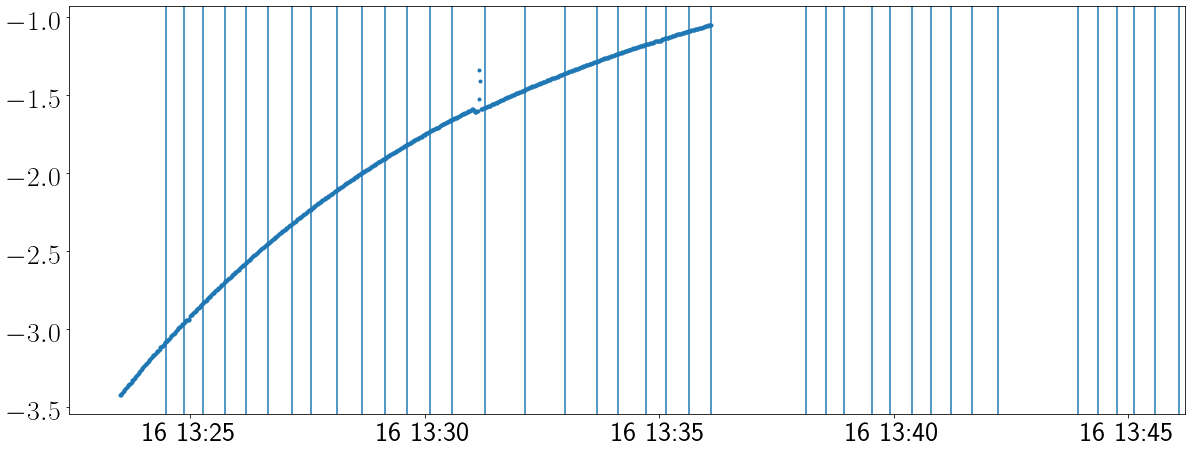

In [20]:
df = first_injection
fig, ax = plt.subplots()
ax.plot(df.index, df['N:IWCMI'],'.')
for t in res_df_FLAT['real_datetime']:
    ax.axvline(t)
plt.show()

In [21]:

# Add traces
df = second_injection
df['time'] = df.index.astype(np.int64)
df['time'] = (df['time']-df['time'].values[0])*1e-9
df = df[df['time']<53]

Is = -df["N:IWCMI_recalibrated_to_IWCMI_absolute"]
I0 = Is.mean()
dI0 = -(Is.max()-Is.min())
dt0 = (df['time'].max()-df['time'].min())
lt0 = -I0/(dI0/dt0)
lt0

673.9194412371911

In [22]:
df = second_injection
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'],
                         y=df["N:IWCMI_recalibrated_to_IWCMI_absolute"],
                    mode='markers',
                    name='Original data'))
fig.show()

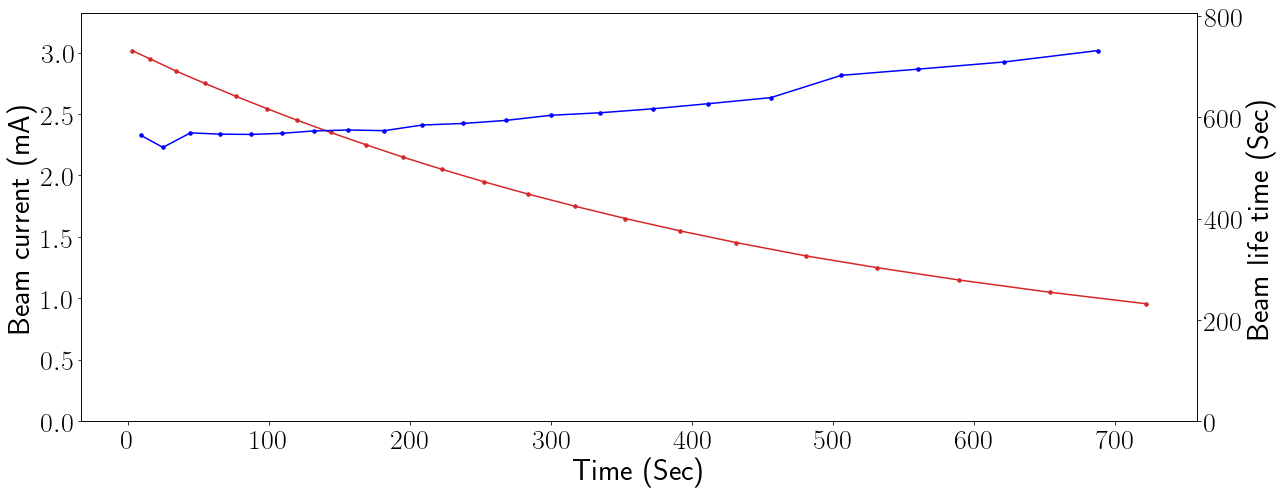

In [23]:
df = first_injection
df['time'] = df.index.astype(np.int64)
df['time'] = (df['time']-df['time'].values[0])*1e-9
before = df[df['time']<452]
after = df[df['time']>455]
after = after[~after['time'].between(459,462)]
scale = 0.98
after["N:IWCMI_recalibrated_to_IWCMI_absolute"] =\
    scale*after["N:IWCMI_recalibrated_to_IWCMI_absolute"]
df_adj = before.append(after)
import plotly.graph_objects as go
fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=df['time'],
                         y=df["N:IWCMI_recalibrated_to_IWCMI_absolute"],
                    mode='markers',
                    name='Original data'))
fig.add_trace(go.Scatter(x=after['time'],
                         y=after["N:IWCMI_recalibrated_to_IWCMI_absolute"],
                    mode='markers',
                    name='Adjusted'))
fig.show()

dI = 0.1
df_adj['I/dI'] = ((df_adj['N:IWCMI_recalibrated_to_IWCMI_absolute']/dI).values).astype(int)
df_adj = df_adj.groupby('I/dI').mean()
ts = df_adj['time'].values
Is = -df_adj['N:IWCMI_recalibrated_to_IWCMI_absolute'].values
Is_lt = (Is[:-1]+Is[1:])/2
ts_lt = (ts[1:]+ts[:-1])/2
dts_lt = (ts[:-1]-ts[1:])
dIs = -(Is[:-1]-Is[1:])
lts = Is_lt/(dIs/dts_lt)
fig, ax = plt.subplots()
ax.plot(ts, Is,'.-',markersize=7, color='tab:red')
ax.set_ylim(0, 1.1*max(Is))
ax.set_ylabel("Beam current (mA)")
ax.set_xlabel("Time (Sec)")
ax1 = ax.twinx()
ax1.plot(ts_lt, lts,'.-',markersize=7, color='blue')
ax1.set_ylim(0, 1.1*max(lts))
ax1.set_ylabel("Beam life time (Sec)")
plt.show()
lt_df = pd.DataFrame({"I (mA)": Is_lt, "Beam life time (Sec)": lts})
lt_df =  pd.DataFrame({"I (mA)": [I0], "Beam life time (Sec)": [lt0]}).append(lt_df)
lt_df = lt_df.reset_index(drop=True)

In [24]:
lt_df.to_csv(shift.get_results_dir().fi("life_time_flat_03_16_2020.csv"))

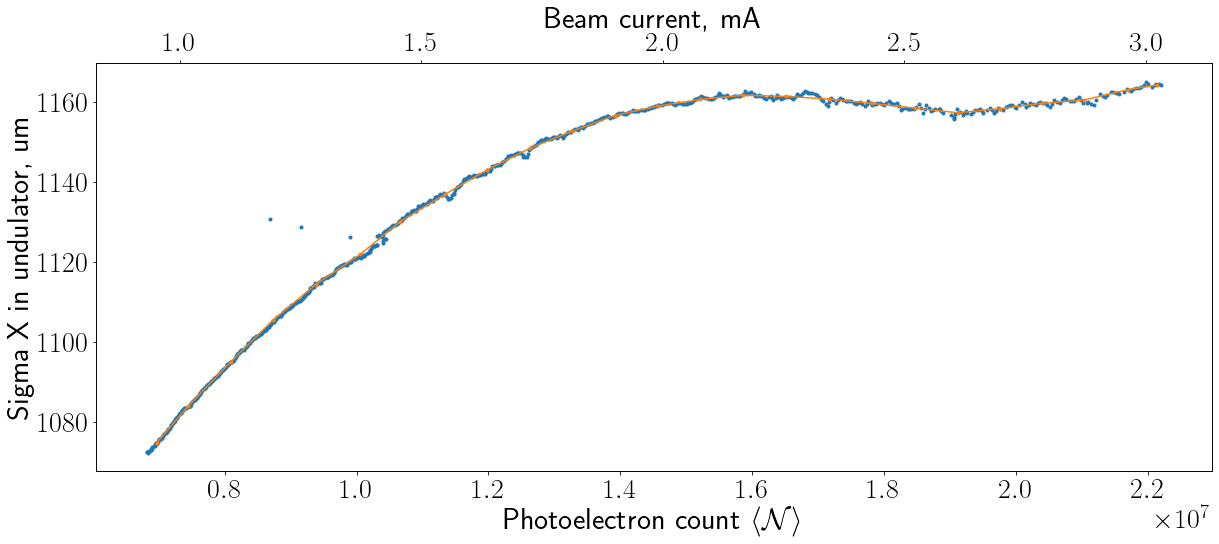

In [25]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_X'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma X in undulator, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save = pd.DataFrame(
    {"N": -df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
     "Sigma_um_X": df['Sigma_um_X']
    })
sx_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_X'], bounds_error=False, fill_value="extrapolate")
sx_interp = sx_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sx_err_stat = np.std(first_injection['Sigma_um_X'].values-sx_interp)
ax.plot(photoel, df['Sigma_um_X'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [26]:
sx_err_stat

1.2726537882868425

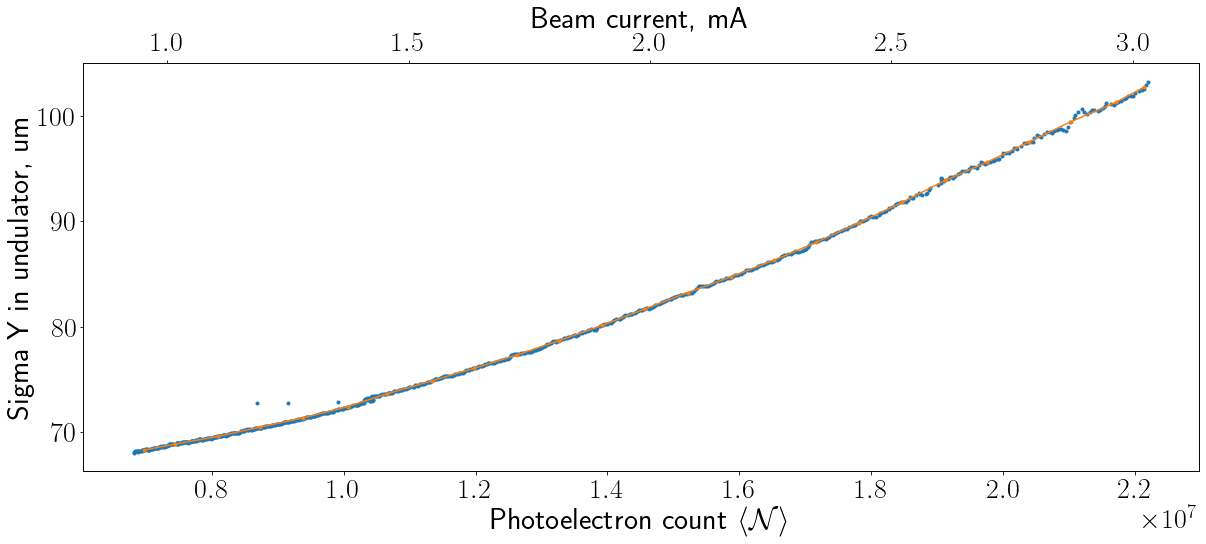

In [27]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['Sigma_um_Y'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save["Sigma_um_Y"] = df['Sigma_um_Y']
sy_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['Sigma_um_Y'], bounds_error=False, fill_value="extrapolate")
sy_interp = sy_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sy_err_stat = np.std(first_injection['Sigma_um_Y'].values-sy_interp)
ax.plot(photoel, df['Sigma_um_Y'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Sigma Y in undulator, um")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [28]:
sy_err_stat

0.14902269134785517

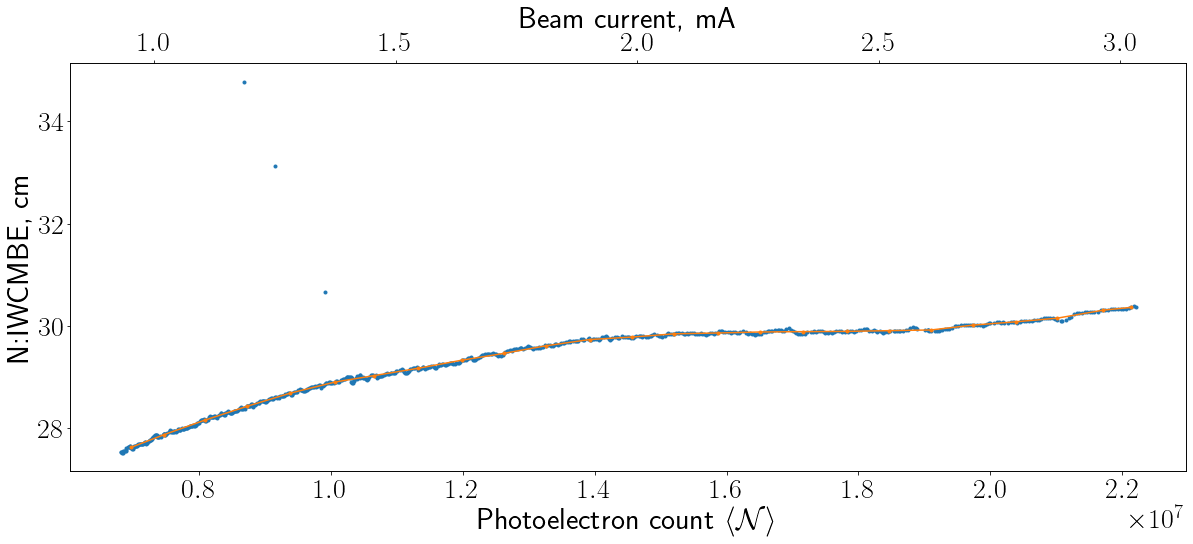

In [29]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBE'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['sz_um'] = 1e4*df['N:IWCMBE'] 
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBE'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBE'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBE'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBE, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [30]:
sz_err_stat

0.051440184011378585

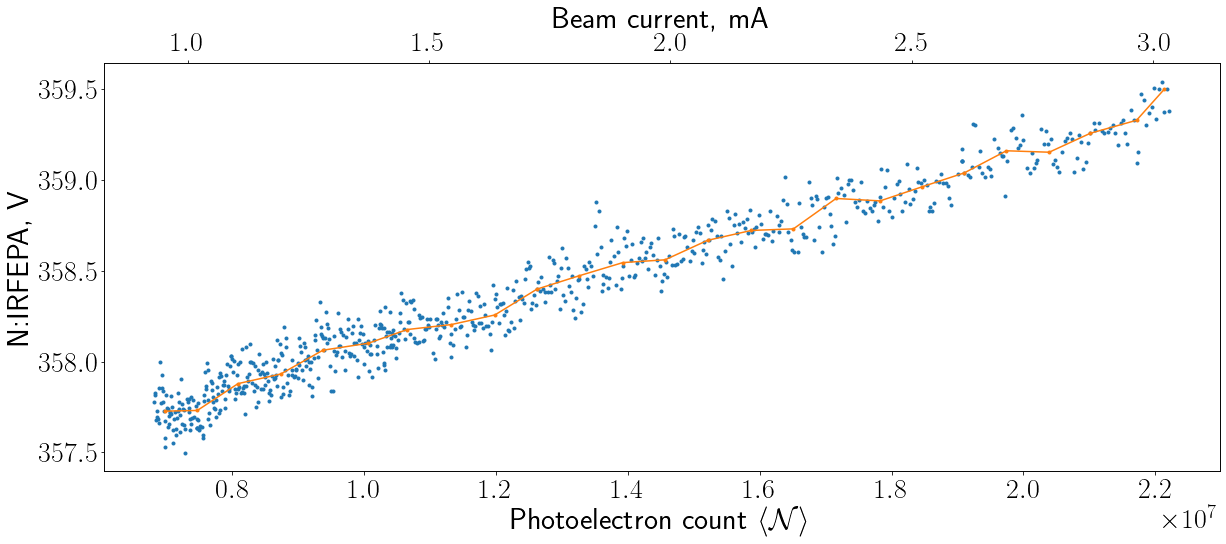

In [31]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IRFEPA'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['N:IRFEPA'] = df['N:IRFEPA'] 
Vrf_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IRFEPA'], bounds_error=False, fill_value="extrapolate")
Vrf_interp = Vrf_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
Vrf_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IRFEPA'].values-Vrf_interp))
ax.plot(photoel, df['N:IRFEPA'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IRFEPA, V")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

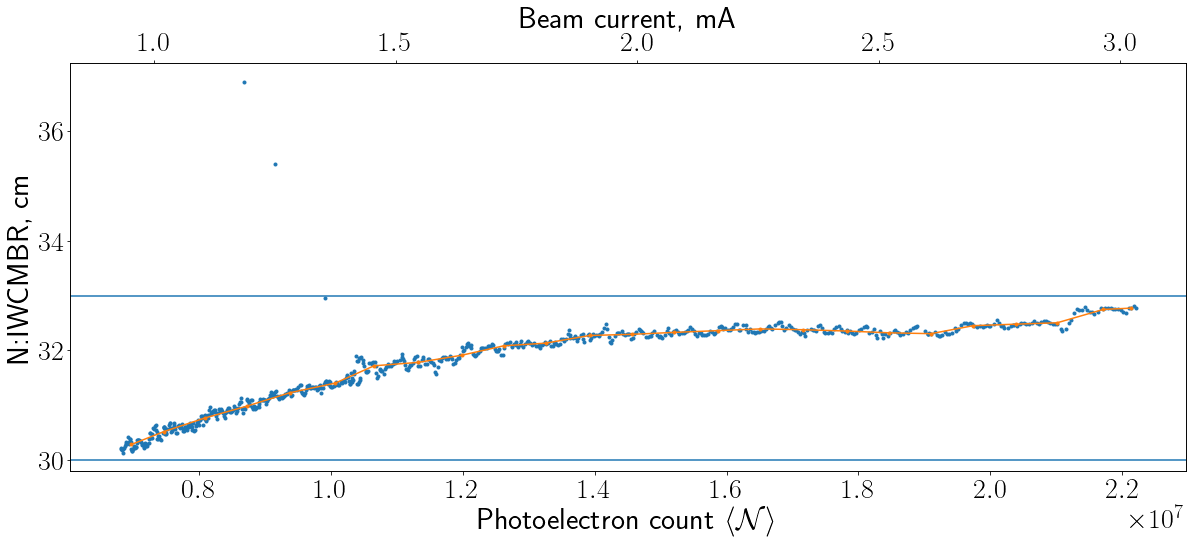

In [32]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
fig, ax = plt.subplots()
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['N:IWCMBR'],'.')
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').median()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['sz_cm_rms'] = df['N:IWCMBR'] 
sz_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['N:IWCMBR'], bounds_error=False, fill_value="extrapolate")
sz_interp = sz_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
sz_err_stat = 1.4826*np.mean(np.absolute(first_injection['N:IWCMBR'].values-sz_interp))
ax.plot(photoel, df['N:IWCMBR'],'.-')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("N:IWCMBR, cm")
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
ax.axhline(30)
ax.axhline(33)
plt.show()

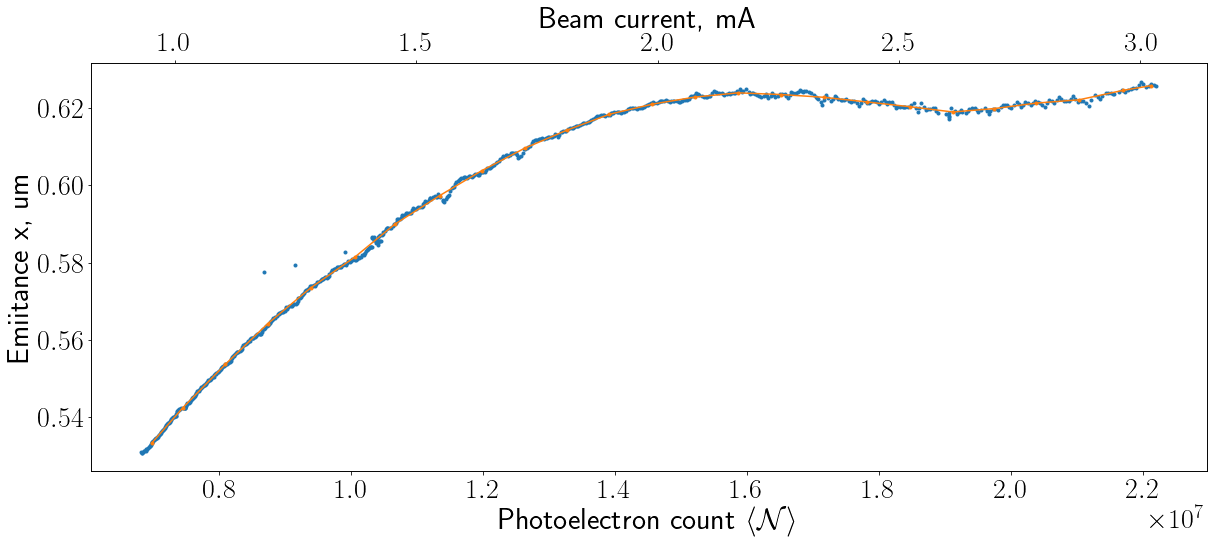

In [33]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ex_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance x, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ex_um'] = df['ex_um']
ex_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ex_um'], bounds_error=False, fill_value="extrapolate")
ex_interp = ex_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ex_err_stat = np.std(first_injection['ex_um'].values-ex_interp)
ax.plot(photoel, df['ex_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

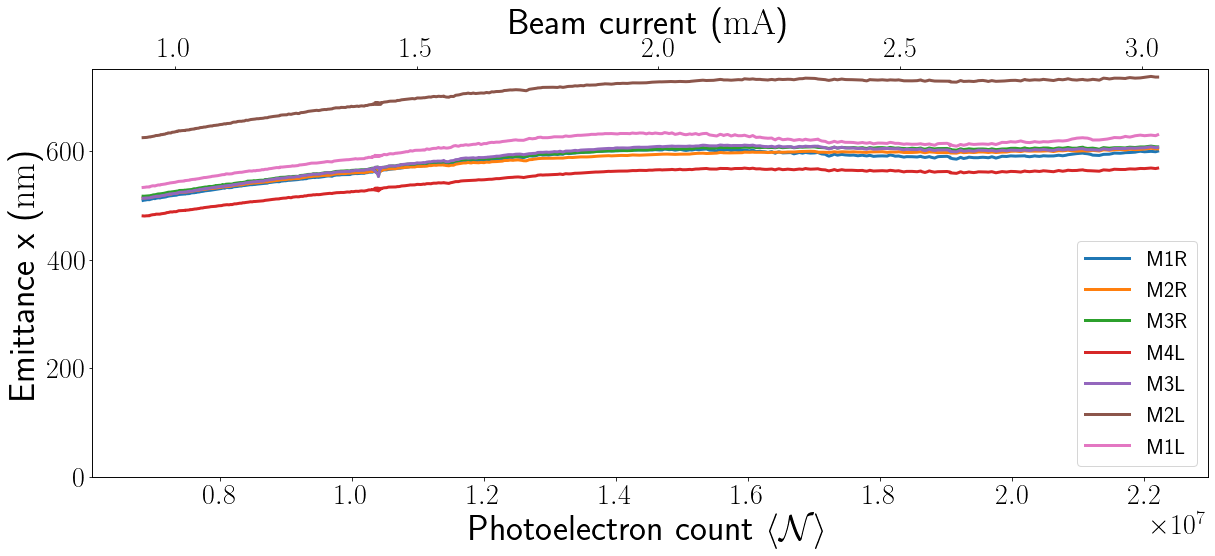

In [34]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
for cam in lattice.active_cameras:
    ax.plot(photoel.rolling(4).max(), 1000*df['e_um_X_'+cam],
            linestyle='-', linewidth=3, label=cam)
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance x (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

In [35]:
camsx = ['e_um_X_'+cam for cam in lattice.active_cameras]
def get_x_errors_one_row(row):
    exfit = row['ex_um']
    excams = row[camsx]
    higher = excams[excams>exfit]
    lower = excams[excams<exfit]
    errhigher = np.sqrt(np.mean((higher-exfit)**2))
    errlower = np.sqrt(np.mean((lower-exfit)**2))
    return {'ex_err_high':errhigher, 'ex_err_low':errlower}
ex_errors = df.apply(get_x_errors_one_row, axis=1, result_type='expand')
ex_err_plus, ex_err_minus = 1000*ex_errors.mean()
ex_err_plus, ex_err_minus

(78.9859603286759, 30.053746789719032)

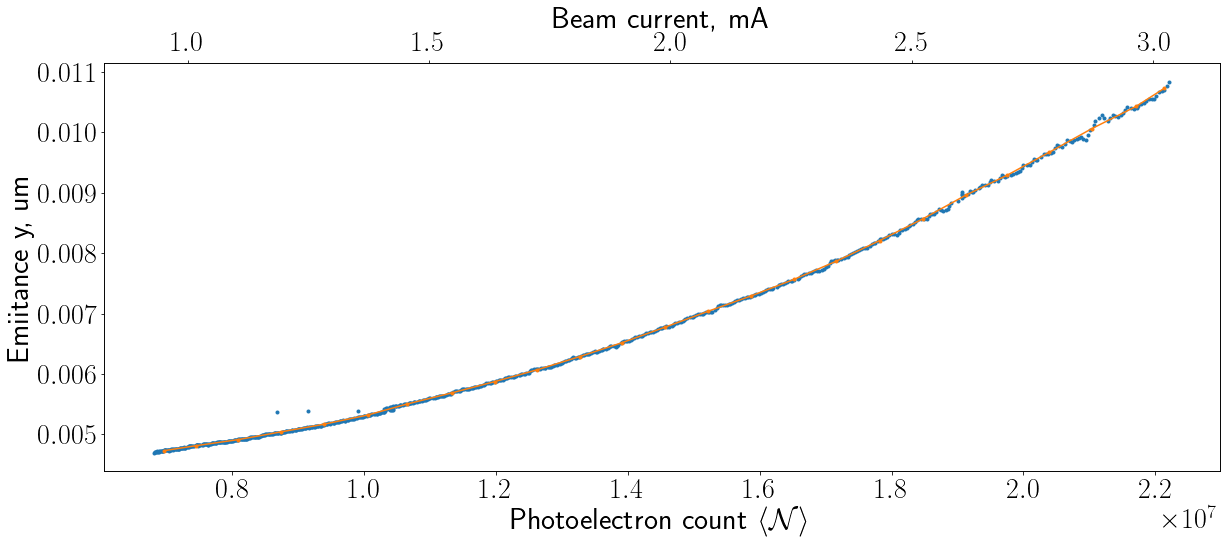

In [36]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['ey_um'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("Emiitance y, um")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['ey_um'] = df['ey_um']
ey_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['ey_um'], bounds_error=False, fill_value="extrapolate")
ey_interp = ey_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
ey_err_stat = np.std(first_injection['ey_um'].values-ey_interp)
ax.plot(photoel, df['ey_um'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.show()

In [37]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi("meas_FLAT_03_16_2020.csv"), index_col=0)

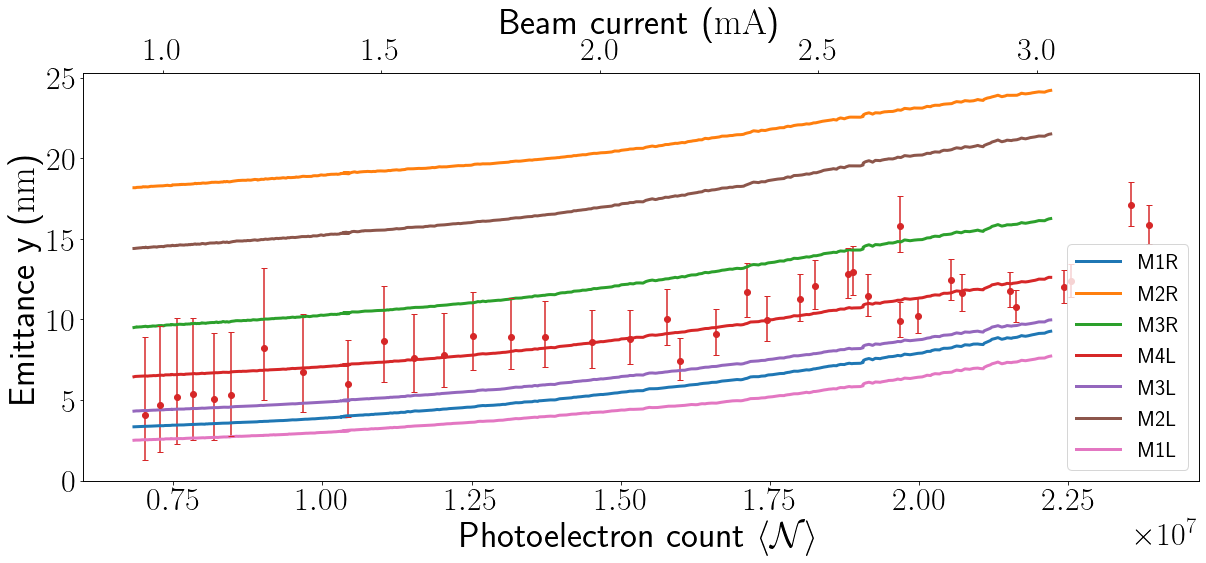

In [38]:
df = first_injection
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 32,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 36
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
for cam in lattice.active_cameras:
    ax.plot(photoel.rolling(4).max(), 1000*df['e_um_Y_'+cam],
            linestyle='-', linewidth=3, label=cam)
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$", fontsize=fs)
ax.set_ylabel("Emittance y (\SI{}{nm})", fontsize=fs)
ax.set_ylim(0, ax.get_ylim()[1])
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
ax.errorbar(meas_FLAT['N'], 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color='tab:red', yerr=yerr)
ax.legend(loc='lower right')
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
plt.savefig(shift.get_results_dir().fi("flat_beam_ey_7_cameras.png"),
            dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 0, 'Beam current measured by WCM (mA)')

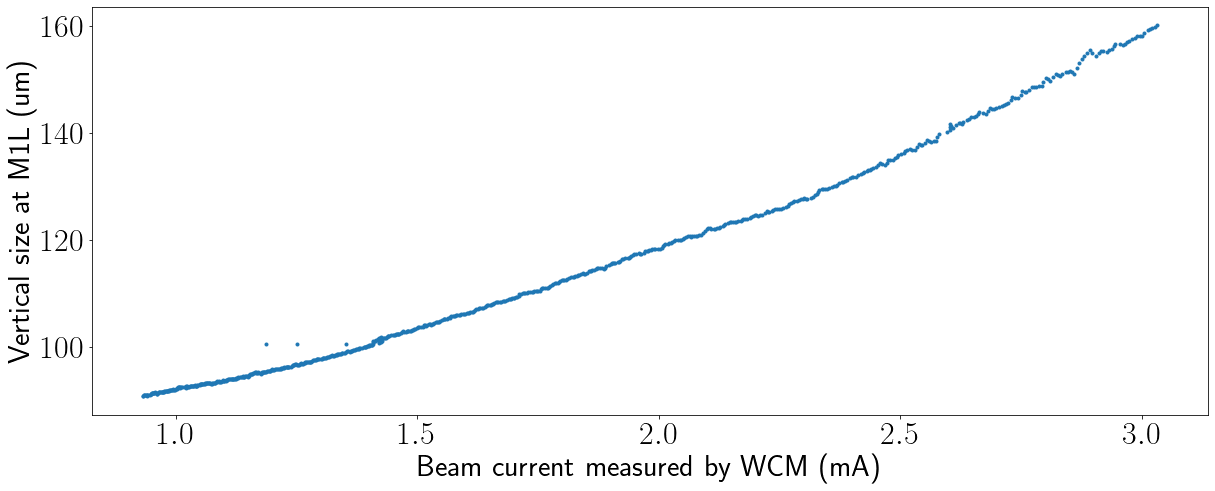

In [39]:
fig, ax = plt.subplots()
ax.plot(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'], first_injection['N:ITC1LSV'],'.')
ax.set_ylabel("Vertical size at M1L (um)")
ax.set_xlabel("Beam current measured by WCM (mA)")

In [40]:
vals = []
for cam in lattice.active_cameras:
    vals.append(min(df['e_um_Y_'+cam].values))
max(vals)/min(vals)

7.261560119806519

In [41]:
import figure_arrange_scripts as ff
hor_separ = 0.05
v_space = 100
fontsize = 200
im_paths = [shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
            shift.get_results_dir().fi("flat_beam_ey_7_cameras.png")]
output_path = path_assistant.get_PRL_images_dir().fi("ex_ey_synclight_7_cameras.png")

Result saved to /home/ilobach/FUR_Run2_experiment_paper/images/ex_ey_synclight_7_cameras.png


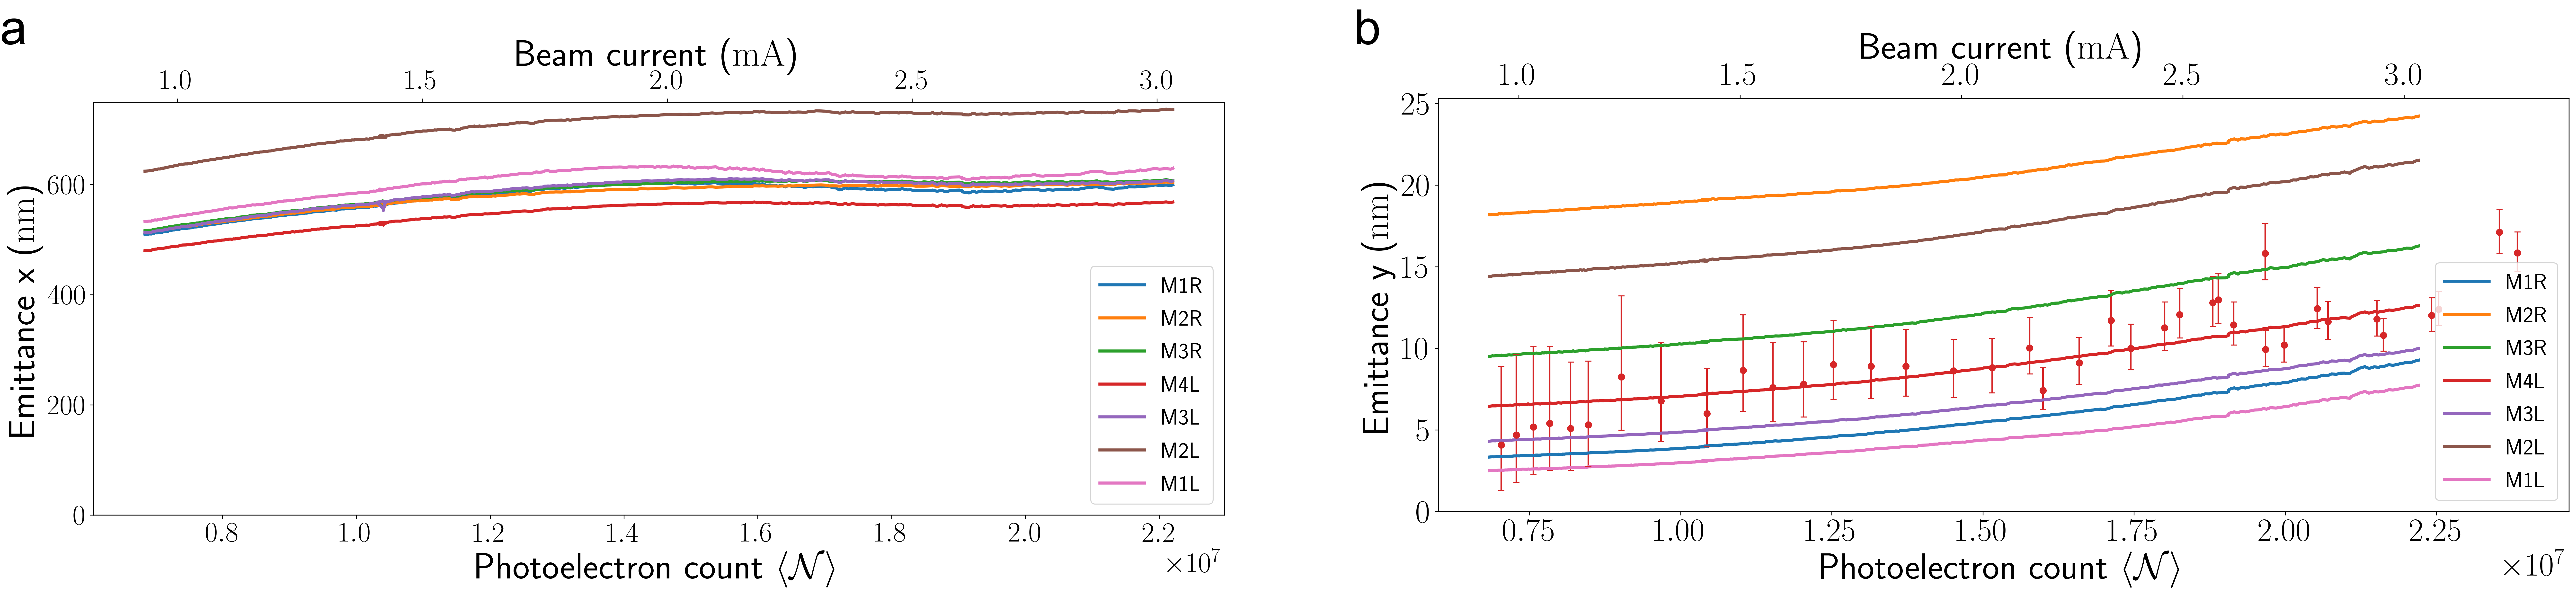

In [42]:
ff.RowOfFigures(im_paths,output_path,
                hor_separ,v_space,fontsize,display_inline=1)

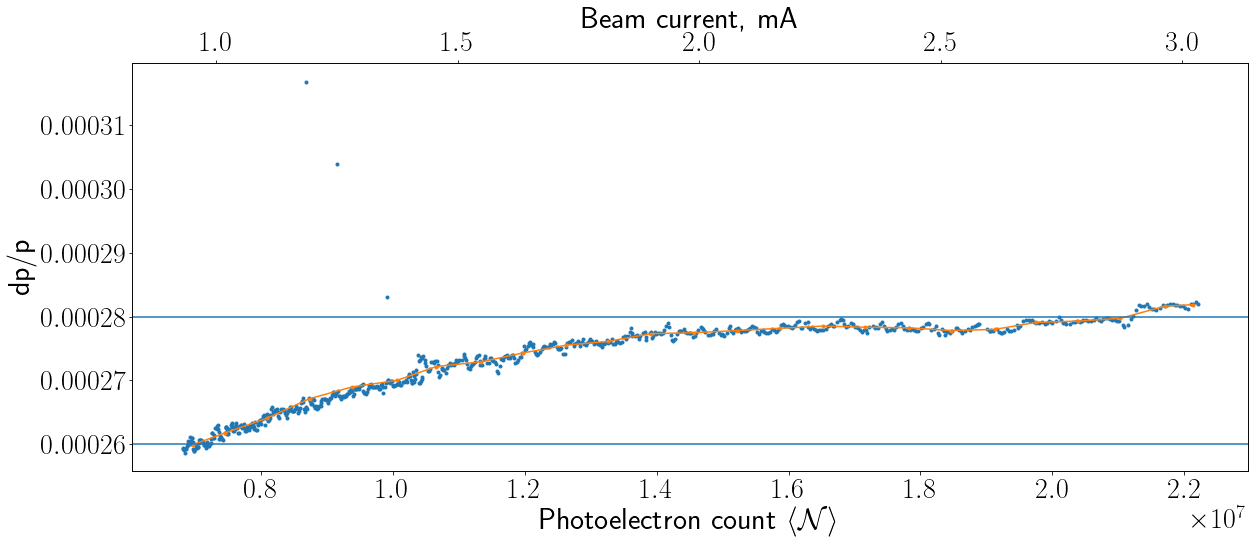

In [43]:
from matplotlib import rc
rc("text", usetex=True)
df = first_injection
plt.rcParams.update({'font.size': 28,'legend.fontsize':22})
i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax.plot(photoel, df['dp/p'],'.')
ax.set_xlabel(r"Photoelectron count $\langle\mathcal{N}\rangle$")
ax.set_ylabel("dp/p")
ax1 = ax.twiny()
dI = 0.1
df = first_injection
df['I/dI'] = ((df['N:IWCMI']/dI).values).astype(int)
df = df.groupby('I/dI').mean()
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
from scipy.interpolate import interp1d
df_to_save['dp/p'] = df['dp/p']
dpp_func = interp1d(-df['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel,
    df['dp/p'], bounds_error=False, fill_value="extrapolate")
dpp_interp = dpp_func(-first_injection['N:IWCMI_recalibrated_to_IWCMI_absolute']*i_to_photoel)
dpp_err_stat = np.std(first_injection['dp/p'].values-ey_interp)
ax.plot(photoel, df['dp/p'],'.-')
ax1.set_xlabel(r"Beam current, mA")
ax1.set_xlim(*[i/i_to_photoel for i in ax.get_xlim()])
ax.axhline(2.6e-4)
ax.axhline(2.8e-4)
plt.show()

In [44]:
df_to_save = df_to_save.sort_values(by='N', ignore_index=True)
df_to_save

N   Sigma_um_X  Sigma_um_Y          sz_um    N:IRFEPA  \
0   6.970485e+06  1074.755619   68.240227  276333.821091  357.727167   
1   7.446600e+06  1083.893437   68.821640  278793.874649  357.731012   
2   8.089468e+06  1094.925283   69.540070  281625.213838  357.878706   
3   8.735432e+06  1105.478758   70.437964  284350.530336  357.931482   
4   9.384630e+06  1114.391929   71.313147  286869.140000  358.062524   
5   1.005973e+07  1121.953419   72.375077  289068.960604  358.100858   
6   1.065794e+07  1130.069963   73.607527  290317.569470  358.176265   
7   1.133906e+07  1136.910163   74.833934  291746.941070  358.203529   
8   1.197997e+07  1143.043341   76.032891  293321.430645  358.256372   
9   1.262796e+07  1148.465745   77.295820  294656.392690  358.398703   
10  1.326804e+07  1152.750801   78.667544  296138.368246  358.471526   
11  1.391468e+07  1156.678248   80.103460  297359.682890  358.544540   
12  1.456632e+07  1159.020866   81.666335  297844.951713  358.559834   
13  1.521416e+07  1160.707419   83.225891  298480.113795  358.666983   
14  1.586702e+07  1161.755423   84.715946  298644.062830  358.721434   
15  1.651909e+07  1161.448687   86.297332  298836.585343  358.730155   
16  1.716266e+07  1160.786937   87.998159  298906.750567  358.897324   
17  1.781897e+07  1159.707301   89.887317  298957.557456  358.884083   
18  1.846938e+07  1158.518065   91.818995  299096.549701  358.962157   
19  1.912338e+07  1157.360856   93.903577  299233.505405  359.038092   
20  1.975188e+07  1158.408835   95.626730  300182.425577  359.159821   
21  2.039129e+07  1159.707909   97.563532  300830.577474  359.151881   
22  2.103286e+07  1160.552508   99.504518  301536.178732  359.256116   
23  2.170556e+07  1163.169362  101.315924  303105.279631  359.327625   
24  2.213368e+07  1164.308640  102.759370  303635.614505  359.497022   

    sz_cm_rms     ex_um     ey_um      dp/p  
0   30.288105  0.533271  0.004732  0.000260  
1   30.524090  0.542485  0.004813  0.000262  
2   30.770068  0.553674  0.004914  0.000264  
3   30.989447  0.564239  0.005042  0.000267  
4   31.230125  0.573464  0.005168  0.000269  
5   31.404535  0.581501  0.005323  0.000270  
6   31.720661  0.589886  0.005506  0.000272  
7   31.782732  0.597297  0.005690  0.000273  
8   31.912991  0.603776  0.005874  0.000274  
9   32.085373  0.609545  0.006071  0.000276  
10  32.133214  0.614222  0.006288  0.000276  
11  32.273297  0.618339  0.006520  0.000277  
12  32.294172  0.620960  0.006777  0.000277  
13  32.329394  0.622790  0.007038  0.000278  
14  32.361721  0.623885  0.007293  0.000278  
15  32.392646  0.623438  0.007567  0.000279  
16  32.378036  0.622732  0.007869  0.000278  
17  32.353801  0.621528  0.008210  0.000278  
18  32.321666  0.620294  0.008567  0.000278  
19  32.306198  0.618930  0.008960  0.000278  
20  32.451744  0.619815  0.009292  0.000279  
21  32.479379  0.621232  0.009672  0.000279  
22  32.504543  0.622073  0.010061  0.000280  
23  32.747594  0.624525  0.010431  0.000282  
24  32.771276  0.625755  0.010730  0.000282

In [45]:
df_to_save.to_csv(shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))

In [46]:
first_injection.to_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"))